<h3><strong>STEP 1: Load Data from Folders</strong></h3>

In [3]:
import pandas as pd
import os
import glob

def load_geo_data(base_path):
    """
    Load geolocation data from all fold directories
    """
    # List all the fold directories
    fold_dirs = [f for f in os.listdir(base_path) if f.startswith('fold=')]
    print("Found folds:", fold_dirs)
    
    # Load and combine all data, adding a 'fold' column
    all_data_frames = []
    
    for fold_dir in fold_dirs:
        fold_number = int(fold_dir.split('=')[1])  # Extract the fold integer
        fold_path = os.path.join(base_path, fold_dir)
        
        # Find all parquet files with the specific naming pattern in this fold directory
        parquet_pattern = os.path.join(fold_path, "part-*.snappy.parquet")
        parquet_files = glob.glob(parquet_pattern)
        print(f"Found {len(parquet_files)} parquet files in {fold_dir}")
        
        # Load all parquet files for this fold
        fold_dfs = []
        for file_path in parquet_files:
            df = pd.read_parquet(file_path)
            fold_dfs.append(df)
        
        # Combine all files for this fold
        if fold_dfs:
            fold_df = pd.concat(fold_dfs, ignore_index=True)
            fold_df['fold'] = fold_number
            all_data_frames.append(fold_df)
    
    # Combine all folds into a single DataFrame
    if all_data_frames:
        geo_df = pd.concat(all_data_frames, ignore_index=True)
        print(f"Full dataset shape: {geo_df.shape}")
        print(f"Unique clients per fold: {geo_df.groupby('fold')['client_id'].nunique()}")
        
        # Display basic info about the loaded data
        print("\nFirst few rows of the combined data:")
        print(geo_df.head())
        print("\nColumn names:")
        print(geo_df.columns.tolist())
        
        return geo_df
    else:
        print("No data found. Please check the file paths.")
        return None

# Execute Step 1
base_path = r"C:\Users\DANNYS\Documents\TAP Code\mbd_mini_dataset\ptls\geo"
geo_df = load_geo_data(base_path)

# Save the raw loaded data
if geo_df is not None:
    geo_df.to_pickle("geo_data_raw.pkl")
    print("Raw data saved to geo_data_raw.pkl")

Found folds: ['fold=0', 'fold=1', 'fold=2', 'fold=3', 'fold=4']
Found 73 parquet files in fold=0
Found 73 parquet files in fold=1
Found 73 parquet files in fold=2
Found 73 parquet files in fold=3
Found 73 parquet files in fold=4
Full dataset shape: (72573, 6)
Unique clients per fold: fold
0    14863
1    14409
2    14396
3    14380
4    14525
Name: client_id, dtype: int64

First few rows of the combined data:
                                           client_id  \
0  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178...   
1  267a58acd5dd260665bd8d144bd0b885e5ba3d64aa016c...   
2  2866a36566d25f8869dc420610728d51c863c0960651b6...   
3  3456e212d3612683462b9a1bcfb86f183f27201fd59f53...   
4  356a9bfd0393827c772473cdf21a6e6197002207a39f08...   

                                          event_time  \
0  [1639659730, 1640075227, 1640075567, 164007819...   
1  [1642411914, 1642573705, 1642681494, 164275863...   
2  [1640529174, 1641129396, 1641219682, 164165575...   
3  [1640594433, 1641116534

<h3><strong>STEP 2: Preprocess Data (Explode Arrays and Convert Timestamps)</strong></h3>

In [10]:
# TEST WITH FIRST ROW ONLY
import pandas as pd
import numpy as np

def test_corrected_explosion(geo_df, row_index=0):
    """
    Test the corrected explosion process on a single row
    """
    print("Testing corrected explosion on first row...")
    
    # Get the first row
    test_row = geo_df.iloc[[row_index]].copy()
    print(f"Original row shape: {test_row.shape}")
    
    # Convert the Unix timestamp arrays to datetime arrays
    test_row['event_time'] = test_row['event_time'].apply(
        lambda x: [pd.to_datetime(ts, unit='s') for ts in x]
    )
    
    # Properly explode all arrays
    exploded_rows = []
    
    for _, row in test_row.iterrows():
        # Get the number of events for this client
        n_events = len(row['event_time'])
        
        print(f"Number of events in this client: {n_events}")
        
        # For each event, create a new row with all values
        for i in range(n_events):
            new_row = {
                'client_id': row['client_id'],
                'event_time': row['event_time'][i],
                'geohash_4': row['geohash_4'][i] if i < len(row['geohash_4']) else None,
                'geohash_5': row['geohash_5'][i] if i < len(row['geohash_5']) else None,
                'geohash_6': row['geohash_6'][i] if i < len(row['geohash_6']) else None,
                'fold': row['fold']
            }
            exploded_rows.append(new_row)
    
    # Create a DataFrame from the exploded rows
    test_exploded = pd.DataFrame(exploded_rows)
    print(f"Exploded row shape: {test_exploded.shape}")
    
    return test_exploded

# Load the raw data if needed
try:
    geo_df
except NameError:
    geo_df = pd.read_pickle("geo_data_raw.pkl")

# Test with the first row
test_result = test_corrected_explosion(geo_df, row_index=0)

# Display the results
print("\nOriginal first row (arrays):")
print(geo_df.iloc[0][['client_id', 'event_time', 'geohash_6', 'fold']])

print("\nExploded first row (individual events):")
print(test_result[['client_id', 'event_time', 'geohash_6', 'fold']].head(10))

# Test geohash decoding on the exploded data
print("\nTesting geohash decoding on exploded data...")

def decode_geohash_value(geohash_val):
    """
    Robust function to decode various geohash formats
    """
    try:
        if pd.isna(geohash_val):
            return (np.nan, np.nan)
            
        # Convert to string if it's a number
        if isinstance(geohash_val, (int, float, np.integer)):
            geohash_str = str(int(geohash_val))
        else:
            geohash_str = str(geohash_val)
            
        # Try to decode
        return gh.decode(geohash_str)
    except Exception as e:
        print(f"Failed to decode '{geohash_val}': {e}")
        return (np.nan, np.nan)

# Test decoding on a few values
print("\nTesting geohash decoding:")
for i, val in enumerate(test_result['geohash_6'].head(5)):
    decoded = decode_geohash_value(val)
    print(f"geohash_6[{i}]: {val} -> {decoded}")

# Check if any values decoded successfully
successful_decodes = 0
for val in test_result['geohash_6'].head(20):
    decoded = decode_geohash_value(val)
    if not pd.isna(decoded[0]):
        successful_decodes += 1

print(f"\nSuccessful decodes in first 20 values: {successful_decodes}/20")

Testing corrected explosion on first row...
Original row shape: (1, 6)
Number of events in this client: 1926
Exploded row shape: (1926, 6)

Original first row (arrays):
client_id     06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178...
event_time    [1639659730, 1640075227, 1640075567, 164007819...
geohash_6     [8131, 8131, 8131, 8131, 8131, 8131, 8131, 813...
fold                                                          0
Name: 0, dtype: object

Exploded first row (individual events):
                                           client_id          event_time  \
0  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-16 13:02:10   
1  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-21 08:27:07   
2  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-21 08:32:47   
3  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-21 09:16:32   
4  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-23 10:27:28   
5  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 20

In [15]:
import pandas as pd
import numpy as np
import os
import glob

# Explode all nested arrays for the entire dataset
def preprocess_geo_data_corrected(geo_df, batch_size=2500, output_dir="processing_batches"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get total number of rows and calculate number of batches
    total_rows = len(geo_df)
    num_batches = (total_rows + batch_size - 1) // batch_size
    print(f"Processing {total_rows} rows in {num_batches} batches of size {batch_size}")
    
    # Process each batch
    all_batch_files = []
    
    for batch_num in range(num_batches):
        print(f"Processing batch {batch_num+1}/{num_batches}")
        
        # Get the current batch
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, total_rows)
        batch_df = geo_df.iloc[start_idx:end_idx].copy()
        
        # Convert the Unix timestamp arrays to datetime arrays
        batch_df['event_time'] = batch_df['event_time'].apply(
            lambda x: [pd.to_datetime(ts, unit='s') for ts in x]
        )
        
        # Properly explode all arrays
        exploded_rows = []
        
        for _, row in batch_df.iterrows():
            # Get the number of events for this client
            n_events = len(row['event_time'])
            
            # For each event, create a new row with all values
            for i in range(n_events):
                new_row = {
                    'client_id': row['client_id'],
                    'event_time': row['event_time'][i],
                    'geohash_4': row['geohash_4'][i] if i < len(row['geohash_4']) else None,
                    'geohash_5': row['geohash_5'][i] if i < len(row['geohash_5']) else None,
                    'geohash_6': row['geohash_6'][i] if i < len(row['geohash_6']) else None,
                    'fold': row['fold']
                }
                exploded_rows.append(new_row)
        
        # Create a DataFrame from the exploded rows for this batch
        batch_exploded = pd.DataFrame(exploded_rows)
        
        # Save this batch to disk
        batch_filename = os.path.join(output_dir, f"batch_{batch_num+1}_of_{num_batches}.pkl")
        batch_exploded.to_pickle(batch_filename)
        all_batch_files.append(batch_filename)
        
        print(f"Batch {batch_num+1} processed and saved to {batch_filename}")
        print(f"  Exploded from {len(batch_df)} to {len(batch_exploded)} rows")
        
        # Clear memory
        del batch_df, batch_exploded, exploded_rows
    
    # Return the list of batch files for later combination
    return all_batch_files

# Combine all batch files into a single DataFrame
def combine_batches(batch_files, output_file="geo_data_preprocessed.pkl"):
    print("Combining all batches...")
    
    # Load and combine all batches
    all_batches = []
    for batch_file in batch_files:
        batch_df = pd.read_pickle(batch_file)
        all_batches.append(batch_df)
    
    # Combine all batches
    geo_df_exploded = pd.concat(all_batches, ignore_index=True)
    print(f"Combined dataset shape: {geo_df_exploded.shape}")
    
    # Save the combined dataset
    geo_df_exploded.to_pickle(output_file)
    print(f"Combined data saved to {output_file}")
    
    return geo_df_exploded

# Execute corrected Step 2
try:
    geo_df
except NameError:
    # Load the raw data if not already in memory
    geo_df = pd.read_pickle("geo_data_raw.pkl")

# Process in batches with the corrected method
batch_files = preprocess_geo_data_corrected(geo_df, batch_size=2500, output_dir="processing_batches")

# Combine all batches
geo_df_exploded = combine_batches(batch_files)

print("Step 2 completed successfully!")

Processing 72573 rows in 30 batches of size 2500
Processing batch 1/30
Batch 1 processed and saved to processing_batches\batch_1_of_30.pkl
  Exploded from 2500 to 2466639 rows
Processing batch 2/30
Batch 2 processed and saved to processing_batches\batch_2_of_30.pkl
  Exploded from 2500 to 2305182 rows
Processing batch 3/30
Batch 3 processed and saved to processing_batches\batch_3_of_30.pkl
  Exploded from 2500 to 2349150 rows
Processing batch 4/30
Batch 4 processed and saved to processing_batches\batch_4_of_30.pkl
  Exploded from 2500 to 2294776 rows
Processing batch 5/30
Batch 5 processed and saved to processing_batches\batch_5_of_30.pkl
  Exploded from 2500 to 2359783 rows
Processing batch 6/30
Batch 6 processed and saved to processing_batches\batch_6_of_30.pkl
  Exploded from 2500 to 2163929 rows
Processing batch 7/30
Batch 7 processed and saved to processing_batches\batch_7_of_30.pkl
  Exploded from 2500 to 2434234 rows
Processing batch 8/30
Batch 8 processed and saved to processin

<h3><strong>STEP 3: Decode Geohashes and Prepare for Feature Engineering</strong></h3>

In [17]:
# Check the processed PKL file before Step 3
import pandas as pd
import numpy as np

def inspect_processed_data(file_path="geo_data_preprocessed.pkl"):
    """
    Inspect the processed data to verify the explosion was done correctly
    """
    try:
        # Load the processed data
        geo_df_processed = pd.read_pickle(file_path)
        print(f"Successfully loaded processed data with {len(geo_df_processed)} rows")
        
        # Display basic information
        print("\n=== DATASET INFO ===")
        print(geo_df_processed.info())
        
        # Display the first few rows
        print("\n=== FIRST 10 ROWS ===")
        print(geo_df_processed.head(10))
        
        # Check if geohash columns are still arrays or individual values
        print("\n=== GEOHASH COLUMNS CHECK ===")
        for col in ['geohash_4', 'geohash_5', 'geohash_6']:
            sample_value = geo_df_processed[col].iloc[0]
            print(f"{col}: {type(sample_value)} - Sample: {sample_value}")
            
            # Check if it's still an array
            if isinstance(sample_value, (list, np.ndarray)):
                print(f"  WARNING: {col} still contains arrays!")
            else:
                print(f"  OK: {col} contains individual values")
        
        # Check data types
        print("\n=== DATA TYPES ===")
        print(geo_df_processed.dtypes)
        
        # Check for missing values
        print("\n=== MISSING VALUES ===")
        print(geo_df_processed.isnull().sum())
        
        return geo_df_processed
        
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Execute the inspection
processed_data = inspect_processed_data("geo_data_preprocessed.pkl")

# If the data still has arrays, we need to fix it before proceeding
if processed_data is not None:
    # Check if any geohash column still contains arrays
    has_arrays = False
    for col in ['geohash_4', 'geohash_5', 'geohash_6']:
        if col in processed_data.columns:
            sample = processed_data[col].iloc[0]
            if isinstance(sample, (list, np.ndarray)):
                has_arrays = True
                print(f"\nERROR: {col} still contains arrays. Step 2 did not work correctly.")
    
    if has_arrays:
        print("The current data still has arrays in the geohash columns, which cannot be decoded.")
    else:
        print("\nData looks good! Proceed to Step 3.")

Successfully loaded processed data with 66295724 rows

=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66295724 entries, 0 to 66295723
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   client_id   object        
 1   event_time  datetime64[ns]
 2   geohash_4   int32         
 3   geohash_5   int32         
 4   geohash_6   int32         
 5   fold        int64         
dtypes: datetime64[ns](1), int32(3), int64(1), object(1)
memory usage: 2.2+ GB
None

=== FIRST 10 ROWS ===
                                           client_id          event_time  \
0  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-16 13:02:10   
1  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-21 08:27:07   
2  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-21 08:32:47   
3  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-21 09:16:32   
4  06de3ac7ec8aa94fd0add2fa7013c5c4d38ac65691d178... 2021-12-23 10:

In [18]:
import pandas as pd
import numpy as np
import pygeohash as gh
from tqdm import tqdm
import os

# Decode geohashes to latitude and longitude coordinates in batches
def decode_geohashes_batch(geo_df_exploded, batch_size=100000, output_file="geo_data_fully_processed.pkl"):
    print("STEP 3: Decoding geohashes and preparing data...")
    
    # Function to decode a geohash integer into (lat, lon)
    def decode_geohash_int(geohash_int):
        try:
            # Convert integer to string and decode
            return gh.decode(str(geohash_int))
        except:
            return (np.nan, np.nan)
    
    # Process in batches to manage memory
    total_rows = len(geo_df_exploded)
    num_batches = (total_rows + batch_size - 1) // batch_size
    print(f"Processing {total_rows} rows in {num_batches} batches of size {batch_size}")
    
    processed_batches = []
    total_dropped = 0
    
    for batch_num in range(num_batches):
        print(f"Processing batch {batch_num+1}/{num_batches}")
        
        # Get the current batch
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, total_rows)
        batch_df = geo_df_exploded.iloc[start_idx:end_idx].copy()
        
        # Decode geohashes with progress bar
        tqdm.pandas(desc="Decoding geohashes")
        batch_df['latitude'] = batch_df['geohash_6'].progress_apply(lambda x: decode_geohash_int(x)[0])
        batch_df['longitude'] = batch_df['geohash_6'].progress_apply(lambda x: decode_geohash_int(x)[1])
        
        # Drop rows with invalid coordinates
        initial_count = len(batch_df)
        batch_df = batch_df.dropna(subset=['latitude', 'longitude'])
        dropped_count = initial_count - len(batch_df)
        total_dropped += dropped_count
        
        if dropped_count > 0:
            print(f"  Dropped {dropped_count} rows with invalid coordinates ({dropped_count/initial_count*100:.1f}%)")
        
        processed_batches.append(batch_df)
        
        # Clear memory
        del batch_df
    
    # Combine all processed batches
    geo_df_processed = pd.concat(processed_batches, ignore_index=True)
    
    # Sort the data by client and time
    geo_df_processed = geo_df_processed.sort_values(['client_id', 'event_time'])
    print(f"Final dataset shape: {geo_df_processed.shape}")
    print(f"Total dropped rows: {total_dropped} ({total_dropped/total_rows*100:.1f}%)")
    
    # Save the fully processed data
    geo_df_processed.to_pickle(output_file)
    print(f"Fully processed data saved to {output_file}")
    
    return geo_df_processed

# Perform basic analysis on the processed data
def analyze_processed_data(geo_df_processed):
    print("\n=== DATA ANALYSIS ===")
    
    # Basic statistics
    print(f"Total events: {len(geo_df_processed):,}")
    print(f"Unique clients: {geo_df_processed['client_id'].nunique():,}")
    
    # Time range
    min_time = geo_df_processed['event_time'].min()
    max_time = geo_df_processed['event_time'].max()
    print(f"Time range: {min_time} to {max_time}")
    print(f"Duration: {max_time - min_time}")
    
    # Events per client
    events_per_client = geo_df_processed.groupby('client_id').size()
    print(f"Average events per client: {events_per_client.mean():.1f}")
    print(f"Min events per client: {events_per_client.min()}")
    print(f"Max events per client: {events_per_client.max()}")
    
    # Coordinate range
    print(f"Latitude range: {geo_df_processed['latitude'].min():.4f} to {geo_df_processed['latitude'].max():.4f}")
    print(f"Longitude range: {geo_df_processed['longitude'].min():.4f} to {geo_df_processed['longitude'].max():.4f}")
    
    return events_per_client

# Execute Step 3
try:
    # Load the preprocessed data from Step 2
    geo_df_exploded = pd.read_pickle("geo_data_preprocessed.pkl")
    print(f"Loaded preprocessed data with {len(geo_df_exploded):,} rows")
    
    # Decode geohashes and process data
    geo_df_processed = decode_geohashes_batch(geo_df_exploded, batch_size=100000)
    
    # Analyze the processed data
    events_per_client = analyze_processed_data(geo_df_processed)
    
    # Display sample of the final processed data
    print("\nSample of processed data:")
    print(geo_df_processed[['client_id', 'event_time', 'geohash_6', 'latitude', 'longitude', 'fold']].head(10))
    
    print("\nStep 3 completed successfully! Ready for feature engineering in Step 4.")

except FileNotFoundError:
    print("Preprocessed data file not found. Please run Step 2 first.")
except Exception as e:
    print(f"Error in Step 3: {e}")

Loaded preprocessed data with 66,295,724 rows
STEP 3: Decoding geohashes and preparing data...
Processing 66295724 rows in 663 batches of size 100000
Processing batch 1/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 137318.13it/s]


Processing batch 2/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176006.37it/s]


Processing batch 3/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177562.76it/s]


Processing batch 4/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165089.13it/s]


Processing batch 5/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180715.28it/s]


Processing batch 6/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177304.17it/s]


Processing batch 7/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181525.95it/s]


Processing batch 8/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177402.26it/s]


Processing batch 9/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181207.30it/s]


Processing batch 10/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178135.51it/s]


Processing batch 11/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178876.60it/s]


Processing batch 12/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175462.76it/s]


Processing batch 13/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180142.24it/s]


Processing batch 14/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168424.64it/s]


Processing batch 15/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174009.21it/s]


Processing batch 16/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180216.93it/s]


Processing batch 17/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178507.76it/s]


Processing batch 18/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181494.68it/s]


Processing batch 19/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178087.18it/s]


Processing batch 20/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172814.69it/s]


Processing batch 21/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177664.67it/s]


Processing batch 22/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174013.68it/s]


Processing batch 23/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179931.81it/s]


Processing batch 24/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181544.10it/s]


Processing batch 25/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179041.31it/s]


Processing batch 26/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171759.94it/s]


Processing batch 27/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180131.95it/s]


Processing batch 28/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168728.31it/s]


Processing batch 29/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173179.95it/s]


Processing batch 30/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136192.94it/s]


Processing batch 31/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176211.94it/s]


Processing batch 32/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171622.97it/s]


Processing batch 33/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178821.47it/s]


Processing batch 34/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176947.53it/s]


Processing batch 35/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160062.34it/s]


Processing batch 36/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158916.45it/s]


Processing batch 37/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158440.04it/s]


Processing batch 38/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168613.81it/s]


Processing batch 39/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129112.60it/s]


Processing batch 40/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172768.98it/s]


Processing batch 41/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135787.43it/s]


Processing batch 42/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144622.00it/s]


Processing batch 43/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156037.57it/s]


Processing batch 44/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154477.91it/s]


Processing batch 45/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131403.18it/s]


Processing batch 46/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155663.47it/s]


Processing batch 47/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151280.58it/s]


Processing batch 48/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155050.17it/s]


Processing batch 49/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161866.37it/s]


Processing batch 50/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 132370.05it/s]


Processing batch 51/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151604.78it/s]


Processing batch 52/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155854.12it/s]


Processing batch 53/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128220.57it/s]


Processing batch 54/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156901.17it/s]


Processing batch 55/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138775.52it/s]


Processing batch 56/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160786.81it/s]


Processing batch 57/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155897.51it/s]


Processing batch 58/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161794.00it/s]


Processing batch 59/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173689.63it/s]


Processing batch 60/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 137153.11it/s]


Processing batch 61/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176860.83it/s]


Processing batch 62/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158507.76it/s]


Processing batch 63/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158650.40it/s]


Processing batch 64/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131693.51it/s]


Processing batch 65/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 148698.49it/s]


Processing batch 66/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152341.38it/s]


Processing batch 67/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 145379.73it/s]


Processing batch 68/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157486.47it/s]


Processing batch 69/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155207.09it/s]


Processing batch 70/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159050.59it/s]


Processing batch 71/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151334.34it/s]


Processing batch 72/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156192.43it/s]


Processing batch 73/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172375.48it/s]


Processing batch 74/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178362.62it/s]


Processing batch 75/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179018.76it/s]


Processing batch 76/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169065.99it/s]


Processing batch 77/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170594.47it/s]


Processing batch 78/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167656.34it/s]


Processing batch 79/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178749.07it/s]


Processing batch 80/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178327.58it/s]


Processing batch 81/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172486.99it/s]


Processing batch 82/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170371.14it/s]


Processing batch 83/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173698.40it/s]


Processing batch 84/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175239.46it/s]


Processing batch 85/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136653.31it/s]


Processing batch 86/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170988.03it/s]


Processing batch 87/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180246.67it/s]


Processing batch 88/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173057.83it/s]


Processing batch 89/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174571.07it/s]


Processing batch 90/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176820.12it/s]


Processing batch 91/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166142.96it/s]


Processing batch 92/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150169.04it/s]


Processing batch 93/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174331.56it/s]


Processing batch 94/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179649.35it/s]


Processing batch 95/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181528.77it/s]


Processing batch 96/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176704.06it/s]


Processing batch 97/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179460.19it/s]


Processing batch 98/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181471.44it/s]


Processing batch 99/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154017.76it/s]


Processing batch 100/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171186.79it/s]


Processing batch 101/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166065.73it/s]


Processing batch 102/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174772.86it/s]


Processing batch 103/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179061.41it/s]


Processing batch 104/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175122.32it/s]


Processing batch 105/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128505.23it/s]


Processing batch 106/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152324.01it/s]


Processing batch 107/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172012.54it/s]


Processing batch 108/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178748.08it/s]


Processing batch 109/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174111.92it/s]


Processing batch 110/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177239.37it/s]


Processing batch 111/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180874.49it/s]


Processing batch 112/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180929.97it/s]


Processing batch 113/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179397.48it/s]


Processing batch 114/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180483.39it/s]


Processing batch 115/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180814.14it/s]


Processing batch 116/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180283.32it/s]


Processing batch 117/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177271.13it/s]


Processing batch 118/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169218.37it/s]


Processing batch 119/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164388.26it/s]


Processing batch 120/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180565.28it/s]


Processing batch 121/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180043.88it/s]


Processing batch 122/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177447.00it/s]


Processing batch 123/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175577.42it/s]


Processing batch 124/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171492.24it/s]


Processing batch 125/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165505.46it/s]


Processing batch 126/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181784.00it/s]


Processing batch 127/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161168.01it/s]


Processing batch 128/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174762.96it/s]


Processing batch 129/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179347.08it/s]


Processing batch 130/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175743.09it/s]


Processing batch 131/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177224.76it/s]


Processing batch 132/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165837.43it/s]


Processing batch 133/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142715.49it/s]


Processing batch 134/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173065.04it/s]


Processing batch 135/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178324.78it/s]


Processing batch 136/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 143289.00it/s]


Processing batch 137/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155585.06it/s]


Processing batch 138/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179801.68it/s]


Processing batch 139/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152078.34it/s]


Processing batch 140/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174430.96it/s]


Processing batch 141/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135667.92it/s]


Processing batch 142/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 139525.92it/s]


Processing batch 143/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168113.23it/s]


Processing batch 144/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157650.67it/s]


Processing batch 145/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152171.70it/s]


Processing batch 146/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169889.87it/s]


Processing batch 147/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177171.68it/s]


Processing batch 148/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171324.47it/s]


Processing batch 149/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165387.67it/s]


Processing batch 150/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175997.51it/s]


Processing batch 151/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168222.05it/s]


Processing batch 152/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 162710.43it/s]


Processing batch 153/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178008.96it/s]


Processing batch 154/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180323.78it/s]


Processing batch 155/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177540.13it/s]


Processing batch 156/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174427.62it/s]


Processing batch 157/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158887.07it/s]


Processing batch 158/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166550.08it/s]


Processing batch 159/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170808.31it/s]


Processing batch 160/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173830.64it/s]


Processing batch 161/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177607.80it/s]


Processing batch 162/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179732.73it/s]


Processing batch 163/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168939.26it/s]


Processing batch 164/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 149839.33it/s]


Processing batch 165/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 141007.57it/s]


Processing batch 166/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166659.94it/s]


Processing batch 167/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173466.51it/s]


Processing batch 168/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181016.25it/s]


Processing batch 169/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174719.71it/s]


Processing batch 170/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179190.92it/s]


Processing batch 171/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160556.80it/s]


Processing batch 172/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166400.16it/s]


Processing batch 173/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177261.16it/s]


Processing batch 174/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177538.48it/s]


Processing batch 175/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179251.57it/s]


Processing batch 176/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179532.62it/s]


Processing batch 177/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179537.93it/s]


Processing batch 178/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179729.80it/s]


Processing batch 179/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180989.15it/s]


Processing batch 180/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168656.46it/s]


Processing batch 181/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174447.35it/s]


Processing batch 182/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156859.33it/s]


Processing batch 183/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177422.60it/s]


Processing batch 184/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178224.53it/s]


Processing batch 185/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154248.85it/s]


Processing batch 186/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156058.47it/s]


Processing batch 187/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174994.68it/s]


Processing batch 188/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181531.99it/s]


Processing batch 189/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160096.25it/s]


Processing batch 190/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177670.47it/s]


Processing batch 191/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176144.74it/s]


Processing batch 192/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171004.35it/s]


Processing batch 193/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174804.98it/s]


Processing batch 194/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172714.49it/s]


Processing batch 195/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164005.86it/s]


Processing batch 196/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179164.36it/s]


Processing batch 197/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179571.06it/s]


Processing batch 198/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154303.50it/s]


Processing batch 199/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172224.58it/s]


Processing batch 200/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177359.06it/s]


Processing batch 201/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157629.52it/s]


Processing batch 202/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172666.71it/s]


Processing batch 203/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151738.01it/s]


Processing batch 204/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156719.43it/s]


Processing batch 205/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163602.78it/s]


Processing batch 206/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155782.05it/s]


Processing batch 207/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159958.69it/s]


Processing batch 208/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152197.54it/s]


Processing batch 209/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136524.18it/s]


Processing batch 210/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142530.52it/s]


Processing batch 211/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144319.14it/s]


Processing batch 212/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151502.60it/s]


Processing batch 213/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142648.36it/s]


Processing batch 214/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155670.35it/s]


Processing batch 215/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155941.44it/s]


Processing batch 216/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 149928.24it/s]


Processing batch 217/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154288.52it/s]


Processing batch 218/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156303.49it/s]


Processing batch 219/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158418.74it/s]


Processing batch 220/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151529.69it/s]


Processing batch 221/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155513.81it/s]


Processing batch 222/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 148244.61it/s]


Processing batch 223/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142965.28it/s]


Processing batch 224/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 141766.46it/s]


Processing batch 225/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 149055.29it/s]


Processing batch 226/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152983.49it/s]


Processing batch 227/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 156042.97it/s]


Processing batch 228/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159729.04it/s]


Processing batch 229/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151957.08it/s]


Processing batch 230/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158683.89it/s]


Processing batch 231/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158712.17it/s]


Processing batch 232/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 149372.67it/s]


Processing batch 233/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150267.01it/s]


Processing batch 234/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 120468.58it/s]


Processing batch 235/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138653.76it/s]


Processing batch 236/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150002.72it/s]


Processing batch 237/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159344.98it/s]


Processing batch 238/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161184.67it/s]


Processing batch 239/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160899.38it/s]


Processing batch 240/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158508.00it/s]


Processing batch 241/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160449.38it/s]


Processing batch 242/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163069.88it/s]


Processing batch 243/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160515.45it/s]


Processing batch 244/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138807.80it/s]


Processing batch 245/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160969.15it/s]


Processing batch 246/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 153849.07it/s]


Processing batch 247/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 148352.41it/s]


Processing batch 248/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 147428.24it/s]


Processing batch 249/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160558.03it/s]


Processing batch 250/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161201.65it/s]


Processing batch 251/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159687.44it/s]


Processing batch 252/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160556.99it/s]


Processing batch 253/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157674.02it/s]


Processing batch 254/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163280.64it/s]


Processing batch 255/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152216.71it/s]


Processing batch 256/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158924.27it/s]


Processing batch 257/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151682.75it/s]


Processing batch 258/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157227.83it/s]


Processing batch 259/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 137941.94it/s]


Processing batch 260/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157723.89it/s]


Processing batch 261/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159184.54it/s]


Processing batch 262/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158448.84it/s]


Processing batch 263/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161746.33it/s]


Processing batch 264/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159030.93it/s]


Processing batch 265/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 162547.30it/s]


Processing batch 266/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160110.92it/s]


Processing batch 267/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158979.51it/s]


Processing batch 268/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158677.89it/s]


Processing batch 269/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161384.43it/s]


Processing batch 270/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157653.93it/s]


Processing batch 271/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133964.29it/s]


Processing batch 272/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142629.98it/s]


Processing batch 273/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158558.69it/s]


Processing batch 274/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179979.37it/s]


Processing batch 275/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173885.78it/s]


Processing batch 276/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170655.21it/s]


Processing batch 277/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155214.67it/s]


Processing batch 278/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178509.73it/s]


Processing batch 279/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 162237.90it/s]


Processing batch 280/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 140995.39it/s]


Processing batch 281/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 153446.91it/s]


Processing batch 282/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131270.96it/s]


Processing batch 283/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 153739.72it/s]


Processing batch 284/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 148372.20it/s]


Processing batch 285/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155428.52it/s]


Processing batch 286/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157448.39it/s]


Processing batch 287/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159162.00it/s]


Processing batch 288/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163287.76it/s]


Processing batch 289/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 162095.70it/s]


Processing batch 290/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 160299.39it/s]


Processing batch 291/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 162832.16it/s]


Processing batch 292/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163238.69it/s]


Processing batch 293/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 153660.19it/s]


Processing batch 294/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159054.57it/s]


Processing batch 295/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159798.41it/s]


Processing batch 296/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142684.42it/s]


Processing batch 297/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 153226.44it/s]


Processing batch 298/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 147518.05it/s]


Processing batch 299/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163549.06it/s]


Processing batch 300/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 153861.26it/s]


Processing batch 301/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155375.73it/s]


Processing batch 302/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179056.75it/s]


Processing batch 303/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177560.65it/s]


Processing batch 304/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178365.65it/s]


Processing batch 305/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179035.35it/s]


Processing batch 306/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176013.17it/s]


Processing batch 307/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175434.58it/s]


Processing batch 308/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173204.12it/s]


Processing batch 309/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:01<00:00, 92825.06it/s]


Processing batch 310/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164072.52it/s]


Processing batch 311/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161386.67it/s]


Processing batch 312/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173184.38it/s]


Processing batch 313/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176192.25it/s]


Processing batch 314/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138324.80it/s]


Processing batch 315/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174520.96it/s]


Processing batch 316/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178811.18it/s]


Processing batch 317/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179161.84it/s]


Processing batch 318/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173888.95it/s]


Processing batch 319/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179348.00it/s]


Processing batch 320/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173170.94it/s]


Processing batch 321/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174806.44it/s]


Processing batch 322/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169394.96it/s]


Processing batch 323/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175086.07it/s]


Processing batch 324/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179976.97it/s]


Processing batch 325/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180927.70it/s]


Processing batch 326/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180039.09it/s]


Processing batch 327/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175991.31it/s]


Processing batch 328/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178096.33it/s]


Processing batch 329/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176734.43it/s]


Processing batch 330/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171288.93it/s]


Processing batch 331/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171558.53it/s]


Processing batch 332/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175263.70it/s]


Processing batch 333/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181648.90it/s]


Processing batch 334/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 182118.90it/s]


Processing batch 335/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 145092.52it/s]


Processing batch 336/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168484.65it/s]


Processing batch 337/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176116.78it/s]


Processing batch 338/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 149541.28it/s]


Processing batch 339/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163441.99it/s]


Processing batch 340/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178008.50it/s]


Processing batch 341/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178518.93it/s]


Processing batch 342/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170765.33it/s]


Processing batch 343/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180573.99it/s]


Processing batch 344/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179871.62it/s]


Processing batch 345/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177057.33it/s]


Processing batch 346/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176606.66it/s]


Processing batch 347/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179136.05it/s]


Processing batch 348/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177935.10it/s]


Processing batch 349/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175240.93it/s]


Processing batch 350/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167324.53it/s]


Processing batch 351/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172876.58it/s]


Processing batch 352/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177826.85it/s]


Processing batch 353/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178940.33it/s]


Processing batch 354/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177347.58it/s]


Processing batch 355/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179554.84it/s]


Processing batch 356/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178076.98it/s]


Processing batch 357/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178468.64it/s]


Processing batch 358/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164807.28it/s]


Processing batch 359/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175253.74it/s]


Processing batch 360/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174515.58it/s]


Processing batch 361/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174731.29it/s]


Processing batch 362/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172489.68it/s]


Processing batch 363/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167789.74it/s]


Processing batch 364/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169840.55it/s]


Processing batch 365/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175719.68it/s]


Processing batch 366/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181989.55it/s]


Processing batch 367/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152389.59it/s]


Processing batch 368/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181355.00it/s]


Processing batch 369/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179942.15it/s]


Processing batch 370/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178907.20it/s]


Processing batch 371/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175136.07it/s]


Processing batch 372/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169320.22it/s]


Processing batch 373/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180148.20it/s]


Processing batch 374/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154198.10it/s]


Processing batch 375/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176274.14it/s]


Processing batch 376/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135328.29it/s]


Processing batch 377/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 169049.70it/s]


Processing batch 378/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154891.22it/s]


Processing batch 379/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179540.31it/s]


Processing batch 380/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180848.91it/s]


Processing batch 381/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177255.47it/s]


Processing batch 382/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174436.11it/s]


Processing batch 383/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181542.76it/s]


Processing batch 384/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165094.85it/s]


Processing batch 385/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180121.89it/s]


Processing batch 386/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172385.33it/s]


Processing batch 387/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180924.03it/s]


Processing batch 388/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181449.46it/s]


Processing batch 389/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136754.36it/s]


Processing batch 390/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164305.45it/s]


Processing batch 391/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180283.63it/s]


Processing batch 392/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 158096.94it/s]


Processing batch 393/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170029.54it/s]


Processing batch 394/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178178.35it/s]


Processing batch 395/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176032.45it/s]


Processing batch 396/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175305.97it/s]


Processing batch 397/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180675.81it/s]


Processing batch 398/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155549.05it/s]


Processing batch 399/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177584.63it/s]


Processing batch 400/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181596.29it/s]


Processing batch 401/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178976.67it/s]


Processing batch 402/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167405.34it/s]


Processing batch 403/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166700.87it/s]


Processing batch 404/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164222.01it/s]


Processing batch 405/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174515.58it/s]


Processing batch 406/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180059.03it/s]


Processing batch 407/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177148.64it/s]


Processing batch 408/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176465.78it/s]


Processing batch 409/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178192.73it/s]


Processing batch 410/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181509.68it/s]


Processing batch 411/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180987.19it/s]


Processing batch 412/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177835.14it/s]


Processing batch 413/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179540.31it/s]


Processing batch 414/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181498.37it/s]


Processing batch 415/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178234.53it/s]


Processing batch 416/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177151.78it/s]


Processing batch 417/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166121.71it/s]


Processing batch 418/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163311.72it/s]


Processing batch 419/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 154704.06it/s]


Processing batch 420/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174024.51it/s]


Processing batch 421/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173008.29it/s]


Processing batch 422/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179093.67it/s]


Processing batch 423/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180756.87it/s]


Processing batch 424/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 183871.02it/s]


Processing batch 425/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150369.64it/s]


Processing batch 426/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179740.04it/s]


Processing batch 427/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176164.72it/s]


Processing batch 428/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171121.56it/s]


Processing batch 429/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180350.99it/s]


Processing batch 430/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173150.78it/s]


Processing batch 431/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172071.96it/s]


Processing batch 432/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 170104.84it/s]


Processing batch 433/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155623.68it/s]


Processing batch 434/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165545.11it/s]


Processing batch 435/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173797.44it/s]


Processing batch 436/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177375.48it/s]


Processing batch 437/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174976.72it/s]


Processing batch 438/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175581.83it/s]


Processing batch 439/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 182415.37it/s]


Processing batch 440/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180597.78it/s]


Processing batch 441/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180379.22it/s]


Processing batch 442/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176095.64it/s]


Processing batch 443/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159494.34it/s]


Processing batch 444/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130493.30it/s]


Processing batch 445/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 146284.08it/s]


Processing batch 446/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173921.61it/s]


Processing batch 447/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177560.43it/s]


Processing batch 448/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181959.23it/s]


Processing batch 449/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 182217.80it/s]


Processing batch 450/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177411.04it/s]


Processing batch 451/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176838.83it/s]


Processing batch 452/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159141.17it/s]


Processing batch 453/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175471.57it/s]


Processing batch 454/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157004.24it/s]


Processing batch 455/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181018.75it/s]


Processing batch 456/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176349.44it/s]


Processing batch 457/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166182.92it/s]


Processing batch 458/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 161193.53it/s]


Processing batch 459/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180990.94it/s]


Processing batch 460/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172975.97it/s]


Processing batch 461/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 141606.65it/s]


Processing batch 462/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 165950.29it/s]


Processing batch 463/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173871.43it/s]


Processing batch 464/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176604.80it/s]


Processing batch 465/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174561.70it/s]


Processing batch 466/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175379.64it/s]


Processing batch 467/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175538.84it/s]


Processing batch 468/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171631.96it/s]


Processing batch 469/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180099.46it/s]


Processing batch 470/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163809.93it/s]


Processing batch 471/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 164473.29it/s]


Processing batch 472/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 143785.76it/s]


Processing batch 473/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174856.80it/s]


Processing batch 474/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177931.78it/s]


Processing batch 475/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151009.83it/s]


Processing batch 476/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 152829.97it/s]


Processing batch 477/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177127.54it/s]


Processing batch 478/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178215.97it/s]


Processing batch 479/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157034.52it/s]


Processing batch 480/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151150.83it/s]


Processing batch 481/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 151394.92it/s]


Processing batch 482/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159707.93it/s]


Processing batch 483/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 155306.23it/s]


Processing batch 484/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163276.19it/s]


Processing batch 485/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167781.29it/s]


Processing batch 486/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179973.19it/s]


Processing batch 487/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 174425.59it/s]


Processing batch 488/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 175353.75it/s]


Processing batch 489/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 180844.23it/s]


Processing batch 490/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181663.77it/s]


Processing batch 491/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 159813.57it/s]


Processing batch 492/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179297.09it/s]


Processing batch 493/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178106.32it/s]


Processing batch 494/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176005.49it/s]


Processing batch 495/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 163309.50it/s]


Processing batch 496/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133333.04it/s]


Processing batch 497/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129199.10it/s]


Processing batch 498/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 146181.30it/s]


Processing batch 499/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168114.98it/s]


Processing batch 500/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179152.73it/s]


Processing batch 501/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 182440.13it/s]


Processing batch 502/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 166998.89it/s]


Processing batch 503/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157859.17it/s]


Processing batch 504/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172498.27it/s]


Processing batch 505/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179024.26it/s]


Processing batch 506/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167099.28it/s]


Processing batch 507/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172956.85it/s]


Processing batch 508/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172024.75it/s]


Processing batch 509/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 168213.35it/s]


Processing batch 510/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 167464.83it/s]


Processing batch 511/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 171532.92it/s]


Processing batch 512/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178660.37it/s]


Processing batch 513/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 178384.69it/s]


Processing batch 514/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181536.63it/s]


Processing batch 515/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 179024.11it/s]


Processing batch 516/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 181187.34it/s]


Processing batch 517/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 177899.18it/s]


Processing batch 518/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176714.48it/s]


Processing batch 519/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173395.23it/s]


Processing batch 520/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 172142.16it/s]


Processing batch 521/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 176170.86it/s]


Processing batch 522/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 173918.08it/s]


Processing batch 523/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 157273.11it/s]


Processing batch 524/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 162735.43it/s]


Processing batch 525/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 119346.64it/s]


Processing batch 526/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142308.74it/s]


Processing batch 527/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 137699.29it/s]


Processing batch 528/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 132717.53it/s]


Processing batch 529/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 123311.80it/s]


Processing batch 530/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142839.96it/s]


Processing batch 531/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136799.14it/s]


Processing batch 532/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127528.19it/s]


Processing batch 533/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129077.27it/s]


Processing batch 534/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129419.20it/s]


Processing batch 535/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 145219.06it/s]


Processing batch 536/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135839.10it/s]


Processing batch 537/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136003.66it/s]


Processing batch 538/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138504.09it/s]


Processing batch 539/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142567.34it/s]


Processing batch 540/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 139263.85it/s]


Processing batch 541/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 143844.44it/s]


Processing batch 542/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126878.85it/s]


Processing batch 543/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 114362.18it/s]


Processing batch 544/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 100979.99it/s]


Processing batch 545/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 116901.66it/s]


Processing batch 546/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 111781.22it/s]


Processing batch 547/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 139322.87it/s]


Processing batch 548/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 107985.12it/s]


Processing batch 549/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 146637.12it/s]


Processing batch 550/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 116374.58it/s]


Processing batch 551/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136632.87it/s]


Processing batch 552/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130793.78it/s]


Processing batch 553/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 121127.33it/s]


Processing batch 554/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136843.59it/s]


Processing batch 555/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128961.98it/s]


Processing batch 556/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127510.24it/s]


Processing batch 557/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129363.55it/s]


Processing batch 558/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 137444.21it/s]


Processing batch 559/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 134009.96it/s]


Processing batch 560/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138415.32it/s]


Processing batch 561/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133278.97it/s]


Processing batch 562/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 122097.21it/s]


Processing batch 563/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126524.24it/s]


Processing batch 564/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 109490.50it/s]


Processing batch 565/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129515.19it/s]


Processing batch 566/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136283.30it/s]


Processing batch 567/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 125694.17it/s]


Processing batch 568/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144222.48it/s]


Processing batch 569/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133925.49it/s]


Processing batch 570/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 125682.31it/s]


Processing batch 571/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 137124.24it/s]


Processing batch 572/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131075.24it/s]


Processing batch 573/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:01<00:00, 94080.34it/s]


Processing batch 574/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:01<00:00, 87886.42it/s]


Processing batch 575/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 112051.17it/s]


Processing batch 576/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 122959.34it/s]


Processing batch 577/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131865.46it/s]


Processing batch 578/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133202.53it/s]


Processing batch 579/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 123919.56it/s]


Processing batch 580/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131210.71it/s]


Processing batch 581/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 117375.82it/s]


Processing batch 582/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 121528.38it/s]


Processing batch 583/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 134734.68it/s]


Processing batch 584/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 134296.37it/s]


Processing batch 585/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129400.83it/s]


Processing batch 586/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133232.87it/s]


Processing batch 587/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 124676.71it/s]


Processing batch 588/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 139102.66it/s]


Processing batch 589/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 139246.74it/s]


Processing batch 590/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 142303.29it/s]


Processing batch 591/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 145006.79it/s]


Processing batch 592/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135579.99it/s]


Processing batch 593/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127016.14it/s]


Processing batch 594/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 132470.22it/s]


Processing batch 595/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 139183.25it/s]


Processing batch 596/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 136823.06it/s]


Processing batch 597/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 143905.15it/s]


Processing batch 598/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133126.35it/s]


Processing batch 599/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 133608.52it/s]


Processing batch 600/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130437.99it/s]


Processing batch 601/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126635.75it/s]


Processing batch 602/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 118162.82it/s]


Processing batch 603/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 124133.41it/s]


Processing batch 604/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 117318.36it/s]


Processing batch 605/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 112357.31it/s]


Processing batch 606/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130446.91it/s]


Processing batch 607/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 132863.58it/s]


Processing batch 608/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 122486.32it/s]


Processing batch 609/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129557.95it/s]


Processing batch 610/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 117929.13it/s]


Processing batch 611/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126701.59it/s]


Processing batch 612/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 117693.65it/s]


Processing batch 613/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128354.49it/s]


Processing batch 614/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131114.41it/s]


Processing batch 615/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130872.13it/s]


Processing batch 616/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144499.98it/s]


Processing batch 617/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 146571.63it/s]


Processing batch 618/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144399.04it/s]


Processing batch 619/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126820.50it/s]


Processing batch 620/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144155.51it/s]


Processing batch 621/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 146578.95it/s]


Processing batch 622/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130900.72it/s]


Processing batch 623/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 117001.57it/s]


Processing batch 624/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 132349.34it/s]


Processing batch 625/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150042.70it/s]


Processing batch 626/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138720.30it/s]


Processing batch 627/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 123485.99it/s]


Processing batch 628/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 118941.46it/s]


Processing batch 629/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 120987.22it/s]


Processing batch 630/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 125419.39it/s]


Processing batch 631/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128715.58it/s]


Processing batch 632/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126009.30it/s]


Processing batch 633/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 131025.77it/s]


Processing batch 634/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 117379.93it/s]


Processing batch 635/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150753.64it/s]


Processing batch 636/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138791.82it/s]


Processing batch 637/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 144997.01it/s]


Processing batch 638/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129074.13it/s]


Processing batch 639/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127173.54it/s]


Processing batch 640/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135995.20it/s]


Processing batch 641/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 150382.80it/s]


Processing batch 642/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 116756.45it/s]


Processing batch 643/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 116148.42it/s]


Processing batch 644/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 138136.29it/s]


Processing batch 645/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 125658.48it/s]


Processing batch 646/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130221.57it/s]


Processing batch 647/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 135223.01it/s]


Processing batch 648/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 129087.28it/s]


Processing batch 649/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 130178.97it/s]


Processing batch 650/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128712.54it/s]


Processing batch 651/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 125031.35it/s]


Processing batch 652/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 128007.07it/s]


Processing batch 653/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 111970.38it/s]


Processing batch 654/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127118.11it/s]


Processing batch 655/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 113957.88it/s]


Processing batch 656/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127888.96it/s]


Processing batch 657/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126795.66it/s]


Processing batch 658/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 118056.92it/s]


Processing batch 659/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 127108.44it/s]


Processing batch 660/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 122419.40it/s]


Processing batch 661/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 126935.64it/s]


Processing batch 662/663


Decoding geohashes: 100%|██████████| 100000/100000 [00:00<00:00, 124447.36it/s]


Processing batch 663/663


Decoding geohashes: 100%|██████████| 95724/95724 [00:00<00:00, 120192.09it/s]


Final dataset shape: (66295724, 8)
Total dropped rows: 0 (0.0%)
Fully processed data saved to geo_data_fully_processed.pkl

=== DATA ANALYSIS ===
Total events: 66,295,724
Unique clients: 72,573
Time range: 2021-12-11 19:27:07 to 2022-12-31 20:59:58
Duration: 385 days 01:32:51
Average events per client: 913.5
Min events per client: 1
Max events per client: 39487
Latitude range: -89.9780 to 22.5000
Longitude range: -179.8242 to -16.8750

Sample of processed data:
                                                  client_id  \
34462137  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462138  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462139  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462140  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462141  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462142  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462143  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
34462144  000032cc38caee45fe03

=== STEP 3 RESULTS INSPECTION ===
Loaded processed data with 66,295,724 rows

1. BASIC DATASET INFO:
Shape: (66295724, 8)

Columns and data types:
client_id             object
event_time    datetime64[ns]
geohash_4              int32
geohash_5              int32
geohash_6              int32
fold                   int64
latitude             float64
longitude            float64
dtype: object

2. MISSING VALUES CHECK:
client_id     0
event_time    0
geohash_4     0
geohash_5     0
geohash_6     0
fold          0
latitude      0
longitude     0
dtype: int64

3. COORDINATE RANGES:
Latitude range: [-89.978027, 22.500000]
Longitude range: [-179.824219, -16.875000]

4. SAMPLE OF DECODED COORDINATES:
          geohash_6   latitude   longitude
18828958       7250 -44.912109  -29.355469
1215691        3504 -27.685547 -134.824219
42985155        770 -27.421875  -33.046875
8693538       10001 -89.978027 -134.934082
61031690       1906 -83.935547 -111.972656
7239260         405 -89.296875  -85.07812

KeyboardInterrupt: 

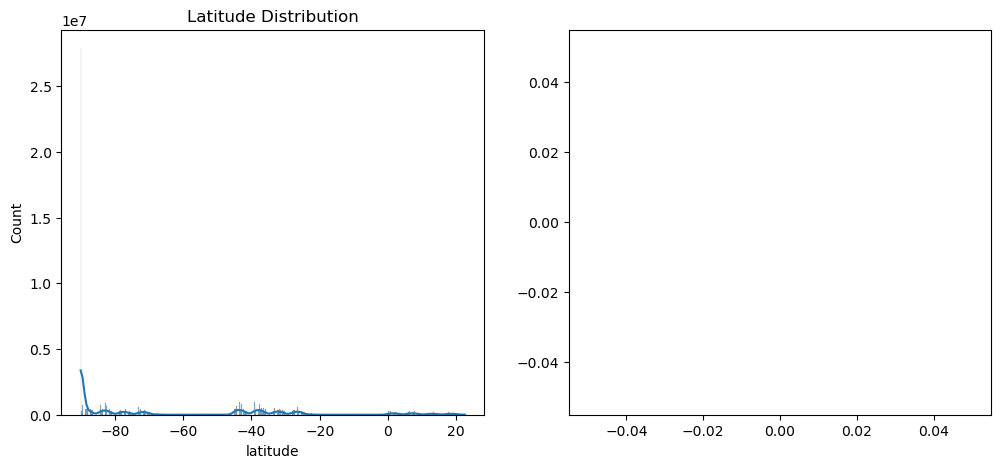

In [19]:
# Step 3 Results Inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def inspect_step3_results(file_path="geo_data_fully_processed.pkl", sample_size=10000):
    """
    Comprehensive inspection of Step 3 results
    """
    print("=== STEP 3 RESULTS INSPECTION ===")
    
    try:
        # Load the processed data
        geo_df_processed = pd.read_pickle(file_path)
        print(f"Loaded processed data with {len(geo_df_processed):,} rows")
        
        # 1. Basic Information
        print("\n1. BASIC DATASET INFO:")
        print(f"Shape: {geo_df_processed.shape}")
        print("\nColumns and data types:")
        print(geo_df_processed.dtypes)
        
        # 2. Check for missing values
        print("\n2. MISSING VALUES CHECK:")
        missing_values = geo_df_processed.isnull().sum()
        print(missing_values)
        
        # 3. Verify coordinate ranges
        print("\n3. COORDINATE RANGES:")
        print(f"Latitude range: [{geo_df_processed['latitude'].min():.6f}, {geo_df_processed['latitude'].max():.6f}]")
        print(f"Longitude range: [{geo_df_processed['longitude'].min():.6f}, {geo_df_processed['longitude'].max():.6f}]")
        
        # 4. Sample of decoded coordinates
        print("\n4. SAMPLE OF DECODED COORDINATES:")
        sample_df = geo_df_processed.sample(min(sample_size, len(geo_df_processed)))
        print(sample_df[['geohash_6', 'latitude', 'longitude']].head(10))
        
        # 5. Check coordinate distribution
        print("\n5. COORDINATE DISTRIBUTION:")
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Latitude distribution
        sns.histplot(geo_df_processed['latitude'].dropna(), ax=axes[0], kde=True)
        axes[0].set_title('Latitude Distribution')
        
        # Longitude distribution
        sns.histplot(geo_df_processed['longitude'].dropna(), ax=axes[1], kde=True)
        axes[1].set_title('Longitude Distribution')
        
        plt.tight_layout()
        plt.savefig('coordinate_distribution.png')
        print("Coordinate distribution plots saved as 'coordinate_distribution.png'")
        
        # 6. Check for impossible coordinates
        print("\n6. IMPOSSIBLE COORDINATE CHECK:")
        # Check for coordinates that are clearly invalid
        invalid_lat = ((geo_df_processed['latitude'] < -90) | (geo_df_processed['latitude'] > 90)).sum()
        invalid_lon = ((geo_df_processed['longitude'] < -180) | (geo_df_processed['longitude'] > 180)).sum()
        print(f"Invalid latitudes (outside [-90, 90]): {invalid_lat}")
        print(f"Invalid longitudes (outside [-180, 180]): {invalid_lon}")
        
        # 7. Check for coordinates that are exactly 0,0 (often indicates decoding errors)
        zero_coords = ((geo_df_processed['latitude'] == 0) & (geo_df_processed['longitude'] == 0)).sum()
        print(f"Coordinates at (0, 0): {zero_coords}")
        
        # 8. Check client distribution
        print("\n7. CLIENT DISTRIBUTION:")
        client_counts = geo_df_processed['client_id'].value_counts()
        print(f"Total clients: {len(client_counts):,}")
        print(f"Average events per client: {client_counts.mean():.1f}")
        print(f"Min events per client: {client_counts.min()}")
        print(f"Max events per client: {client_counts.max()}")
        
        # 9. Time range check
        print("\n8. TIME RANGE:")
        print(f"Earliest event: {geo_df_processed['event_time'].min()}")
        print(f"Latest event: {geo_df_processed['event_time'].max()}")
        
        # 10. Fold distribution
        print("\n9. FOLD DISTRIBUTION:")
        fold_counts = geo_df_processed['fold'].value_counts().sort_index()
        print(fold_counts)
        
        return geo_df_processed
        
    except FileNotFoundError:
        print(f"File {file_path} not found. Please run Step 3 first.")
        return None
    except Exception as e:
        print(f"Error during inspection: {e}")
        return None

# Execute the inspection
processed_data = inspect_step3_results()

if processed_data is not None:
    print("\n=== INSPECTION COMPLETE ===")
    print("Based on this inspection, we can determine if Step 3 was successful")
    print("and whether we can proceed to Step 4 (Feature Engineering).")
    
    # Check if there are any critical issues that need to be addressed
    missing_coords = processed_data[['latitude', 'longitude']].isnull().sum().sum()
    if missing_coords > 0:
        print(f"\nWARNING: Found {missing_coords} missing coordinates. This might affect feature engineering.")
    
    invalid_coords = ((processed_data['latitude'] < -90) | (processed_data['latitude'] > 90) | 
                     (processed_data['longitude'] < -180) | (processed_data['longitude'] > 180)).sum()
    if invalid_coords > 0:
        print(f"WARNING: Found {invalid_coords} invalid coordinates outside valid ranges.")
    
    if missing_coords == 0 and invalid_coords == 0:
        print("\n✓ Step 3 completed successfully. Data is ready for Step 4 (Feature Engineering).")
    else:
        print("\n⚠ Step 3 completed with some issues. We may need to clean the data before Step 4.")